# Анализ тональности комментариев

## Постановка задачи

Интернет-магазин запускает новый сервис - пользователи cмогут редактировать и дополнять описания товаров. Клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать "токсичные комментарии" и отправлять их на модерацию. 

Необходимо создать модель классификации комментариев на позитивные и негативные. Для обучения есть набор данных с разметкой о токсичности. Значение метрики качества `f1` должно быть не ниже *`0.75`*

## Импорт библиотек, установка констант

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import notebook

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk import word_tokenize, pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve

from catboost import Pool, CatBoostClassifier
import optuna

import warnings
warnings.filterwarnings('ignore')

RND_ST=42
N_FOLDS=3

## Загрузка и предобработка

In [2]:
data = pd.read_csv('datasets/toxic_comments.csv', usecols=[1, 2])
data['text'] = data['text'].str.lower()

In [3]:
data.sample(10, random_state=RND_ST)

,text,toxic
31015,"sometime back, i just happened to log on to ww...",0
102832,"""\n\nthe latest edit is much better, don't mak...",0
67317,""" october 2007 (utc)\n\ni would think you'd be...",0
81091,thanks for the tip on the currency translation...,0
90091,i would argue that if content on the con in co...,0
1860,"""=reliable sources===\ncheating:\n""""barry bond...",1
125293,wtf=\n\nhow the fuck does this person merit a ...,1
148986,"cajuns, acadians\ncajuns, acadians, louisianan...",0
89697,hi - i dropped a pin in google maps at the cer...,0
64256,re removal of accessdate= for urls books \n\nt...,0


Баланс классов

In [4]:
(
    data['toxic'].value_counts().to_frame()
    .assign(percent = lambda x: round(x / x['toxic'].sum()*100) )
)

,toxic,percent
0,143106,90.0
1,16186,10.0


Есть дисбаланс, поэтому обязательно нужно указывать на это моделям

### Лемматизация

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Atolkachev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Atolkachev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Atolkachev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Atolkachev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Atolkachev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
wnl = WordNetLemmatizer()

Функция предобработки текста

In [7]:
def text_prep(text):
    """
    функция лемматизации
    """
    # оставляем только буквы
    txt_prep = re.sub(r"[^a-zA-Z]", " ", text)    
    lemm_lst = []
    # разбиваем на токены, получаем отметки о части речи
    for token, tag in pos_tag(word_tokenize(txt_prep.lower())): 
        pos = tag[0].lower()
        if pos not in ["a", "r", "n", "v"]:
            pos = "n"
        # лемматизируем
        lemm_lst.append(wnl.lemmatize(token, pos)) 
                            
    return " ".join(lemm_lst)

Применяем функцию `text_prep` к столбцу `data['text']`. Обработку делаем батчами по 500 записей.

In [8]:
text_lemm = []
batch_size = 500
for i in notebook.tqdm(range(data.shape[0]//batch_size +1)):
    batch = data['text'][batch_size*i : batch_size*(i+1)]
    batch_lemm = batch.apply(text_prep)
    text_lemm =  text_lemm + batch_lemm.to_list()

  0%|          | 0/319 [00:00<?, ?it/s]

Список из лемматизированных записей сохраняем в столбец `text_lemm`

In [9]:
data['text_lemm'] = pd.Series(text_lemm, index=data.index)
data.sample(10, random_state=RND_ST)

,text,toxic,text_lemm
31015,"sometime back, i just happened to log on to ww...",0,sometime back i just happen to log on to www i...
102832,"""\n\nthe latest edit is much better, don't mak...",0,the latest edit be much better don t make this...
67317,""" october 2007 (utc)\n\ni would think you'd be...",0,october utc i would think you d be able to get...
81091,thanks for the tip on the currency translation...,0,thanks for the tip on the currency translation...
90091,i would argue that if content on the con in co...,0,i would argue that if content on the con in co...
1860,"""=reliable sources===\ncheating:\n""""barry bond...",1,reliable source cheat barry bond cheater from ...
125293,wtf=\n\nhow the fuck does this person merit a ...,1,wtf how the fuck do this person merit a page o...
148986,"cajuns, acadians\ncajuns, acadians, louisianan...",0,cajun acadian cajun acadian louisianan they re...
89697,hi - i dropped a pin in google maps at the cer...,0,hi i drop a pin in google map at the ceremonia...
64256,re removal of accessdate= for urls books \n\nt...,0,re removal of accessdate for url book this be ...


Удаляем дубликаты

In [10]:
data[['text_lemm', 'toxic']].duplicated().sum()

1313

In [11]:
data_fltr = data[['text_lemm', 'toxic']].drop_duplicates()

**ВЫВОД** в переменной `data_fltr` сохранены предобработанные данные

### Векторизация методом `TF-IDF`

Разбиваем на тренировочные и тестовые данные, формируем соответствующие корпуса.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    data_fltr['text_lemm'], data_fltr['toxic'], test_size=.25, random_state=RND_ST
)

In [13]:
corpus_trn = X_train.values               
corpus_tst = X_test.values  

Инициируем класс `TfidfVectorizer()` для векторизации, указываем `stop_words`. Обучение проводим на тренировочном корпусе, тестовый корпус преобразуем обученным классом.

In [14]:
count_tf_idf = TfidfVectorizer(stop_words=nltk_stopwords.words('english'))
fch_trn = count_tf_idf.fit_transform(corpus_trn)
fch_tst = count_tf_idf.transform(corpus_tst)

Проверяем размерности

In [15]:
pd.DataFrame([[X_train.shape, fch_trn.shape],
              [X_test.shape, fch_tst.shape]],
             columns=('Series length', 'Feature matrix'),
             index=('Train', 'Test'))

,Series length,Feature matrix
Train,"(118484,)","(118484, 131213)"
Test,"(39495,)","(39495, 131213)"


удаляем лишние переменные

In [16]:
del data
del text_lemm
del X_train
del X_test
del corpus_tst

Признаки подготовлены, можно переходить к проверке моделей

**ВЫВОД** при векторизации с применением TF-IDF кодирования получили матрицу с 130+ тыс признаков.

## Оптимизация моделей

### Logistic Regression

В качестве `baseline` попробуем `LogisticRegression`. Зададим минимум параметров и замерим целевую метрику `f1` на кросс-валидации.

In [17]:
lr_params = {'multi_class': 'ovr',
             'class_weight': 'balanced',   # обязательно указываем т.к. есть дисбаланс классов
             'solver': 'liblinear'}

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RND_ST)

In [18]:
lr_cv_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))),
                           ('clf', LogisticRegression(**lr_params, random_state =RND_ST))])

LogRgr_score = cross_validate(lr_cv_pipeline,
                              corpus_trn,
                              y_train,
                              scoring=['f1'],
                              cv=kf,
                              verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................... f1: (test=0.737) total time=   7.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] END ................................... f1: (test=0.735) total time=   7.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.1s remaining:    0.0s


[CV] END ................................... f1: (test=0.742) total time=   7.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.0s finished


In [19]:
LogRgr_base_CV = pd.DataFrame(data=[LogRgr_score['test_f1'].mean()],
                             columns=['f1'],
                             index=['LogisticRegression_Base_CV'])
LogRgr_base_CV

,f1
LogisticRegression_Base_CV,0.738075


Можно попытаться повысить метрику, подобрав значение коэффициента `C`. Оптимизацию проведем с помощью библиотеки `optuna`.

In [20]:
def objective_LogRgr(trial, features=corpus_trn, target=y_train):
    
    X_trn, X_val, y_trn, y_val = train_test_split(
        features, target, test_size=.25, random_state=RND_ST
    )
    
    X_trn_vect = count_tf_idf.fit_transform(X_trn)
    X_val_vect = count_tf_idf.transform(X_val)
    
    params = {'multi_class': 'ovr',
              'class_weight': 'balanced',
              'solver': 'liblinear',
              'C': trial.suggest_float('C', 10.2, 10.3)}
    
    model = LogisticRegression(**params, random_state=RND_ST)
    model.fit(X_trn_vect, y_trn)
    
    return f1_score(y_val, model.predict(X_val_vect))

In [21]:
study_logrgr = optuna.create_study(direction = 'maximize', study_name='LogisticRegression')
study_logrgr.optimize(objective_LogRgr, n_trials=10)

[I 2023-04-03 22:14:27,884] A new study created in memory with name: LogisticRegression
[I 2023-04-03 22:14:36,983] Trial 0 finished with value: 0.7467716535433071 and parameters: {'C': 10.271551322824536}. Best is trial 0 with value: 0.7467716535433071.
[I 2023-04-03 22:14:46,153] Trial 1 finished with value: 0.7468892739014019 and parameters: {'C': 10.287050004982536}. Best is trial 1 with value: 0.7468892739014019.
[I 2023-04-03 22:14:55,625] Trial 2 finished with value: 0.747048638438533 and parameters: {'C': 10.234333982639503}. Best is trial 2 with value: 0.747048638438533.
[I 2023-04-03 22:15:05,070] Trial 3 finished with value: 0.7470069313169503 and parameters: {'C': 10.296001304193075}. Best is trial 2 with value: 0.747048638438533.
[I 2023-04-03 22:15:14,356] Trial 4 finished with value: 0.7467716535433071 and parameters: {'C': 10.269957620943119}. Best is trial 2 with value: 0.747048638438533.
[I 2023-04-03 22:15:23,879] Trial 5 finished with value: 0.747048638438533 and pa

Дополняем словарь параметров найденным значением, инициируем модель с новыми параметрами, снова замеряем `f1` для "улучшенной" модели.

In [22]:
lr_params.update(study_logrgr.best_params)

In [23]:
lr_tuned_cv_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))),
                                 ('clf', LogisticRegression(**lr_params, random_state=RND_ST))])

LogRgr_tuned_score = cross_validate(lr_tuned_cv_pipeline,
                                    corpus_trn,
                                    y_train,
                                    scoring=['f1'],
                                    cv=kf,
                                    verbose=3)

LogRgr_tuned_CV = pd.DataFrame(
    data=[LogRgr_tuned_score['test_f1'].mean()],
    columns=['f1'],
    index=['LogisticRegression_Tuned_CV']
)

pd.concat([LogRgr_base_CV, LogRgr_tuned_CV]).sort_values('f1', ascending=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................... f1: (test=0.752) total time=   8.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] END ................................... f1: (test=0.756) total time=   8.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV] END ................................... f1: (test=0.757) total time=   8.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s finished


,f1
LogisticRegression_Tuned_CV,0.754935
LogisticRegression_Base_CV,0.738075


Следующим шагом подберем оптимальный порог классификации.

In [24]:
X_trn, X_val, y_trn, y_val = train_test_split(
    corpus_trn, y_train, test_size=.25, random_state=RND_ST
)
    
X_trn_vect = count_tf_idf.fit_transform(X_trn)
X_val_vect = count_tf_idf.transform(X_val)

lr_model_tuned = LogisticRegression(**lr_params, random_state=RND_ST)
lr_model_tuned.fit(X_trn_vect, y_trn)
lr_tuned_probs = lr_model_tuned.predict_proba(X_val_vect)

precision, recall, thresholds = precision_recall_curve(
    y_val, lr_tuned_probs[:, 1], pos_label=1
)
f1_metric = (2*precision*recall/(precision+recall))

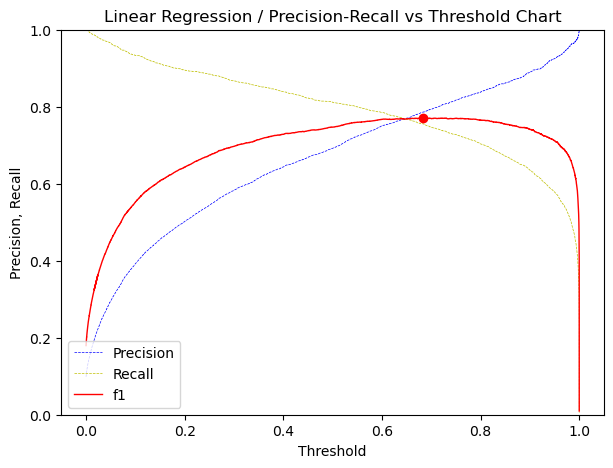

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Linear Regression / Precision-Recall vs Threshold Chart')
plt.plot(thresholds, precision[: -1], 'b--', label='Precision', lw=.5)
plt.plot(thresholds, recall[: -1], 'y--', label='Recall', lw=.5)
plt.plot(thresholds, f1_metric[: -1], 'r', label='f1', lw=1)
plt.plot(thresholds[np.argmax(f1_metric)], max(f1_metric), 'ro--', lw=4)
ax.set_ylabel('Precision, Recall')
ax.set_xlabel('Threshold')
ax.legend(loc='lower left')
ax.set_ylim([0,1])
plt.show()

In [28]:
lr_opt_thrsh = thresholds[np.argmax(f1_metric)]
print('оптимальный порог:\t', lr_opt_thrsh, '\nзначение f1:\t\t', max(f1_metric))

оптимальный порог:	 0.6841345207007576 
значение f1:		 0.7708951317396615


**ВЫВОД** для модели `LogisticRegression` найдены оптимальные гиперпараметры:
- коэфф. C (Inverse of regularization strength) = 10.234
- порог классификации 0.684

### CatBoost Classifier

Тестируем базовую модель - задаем минимальные параметры, замеряем метрику `f1` на кроссвалидации

In [29]:
cbc_params = {'loss_function': 'Logloss',
              'auto_class_weights' :'Balanced', # обязательно указываем т.к. есть дисбаланс классов
              'verbose': 0}

In [30]:
cbc_cv_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))),
                            ('clf', CatBoostClassifier(**cbc_params, random_state=RND_ST))])

CBC_score = cross_validate(cbc_cv_pipeline,
                           corpus_trn,
                           y_train,
                           scoring=['f1'],
                           cv=kf,
                           verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................... f1: (test=0.745) total time=19.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.3min remaining:    0.0s


[CV] END ................................... f1: (test=0.748) total time=19.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 38.7min remaining:    0.0s


[CV] END ................................... f1: (test=0.750) total time=19.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 58.3min finished


In [31]:
CBC_base_CV = pd.DataFrame(
    data=[CBC_score['test_f1'].mean()],
    columns=['f1'],
    index=['CatBoost_Base_CV']
)
CBC_base_CV

,f1
CatBoost_Base_CV,0.747606


Модель "из коробки" показала неплохую метрику. Переходим к оптимизации. Аналогично - воспользуемся `optuna`.

<div class="alert alert-info"> <b>Комментарий</b>

1. Поиск оптимальных гиперпараметров производим на 7% тренировочных данных. Это минимум, который приводит к результатам, сравнимым с полным тренировочным объемом данных. Причина - мало памяти.

2. Поскольку мы 
    берем только 7% от тренировочных данных для оптимизации, то придется их "отрезать" от уже векторизированных признаков. Иначе у нас меняется число признаков. Пусть метрики на оптимизации у нас не совсем достоверные, но нам важен сам факт при каких параметрах они максимальны и нам важно сохранить структуру данных - в нашем случае число признаков.
    
</div>

Для подготовки "урезанного" объема данных воспользуемся `train_test_split`, чтоб не нарушить баланс классов.

In [32]:
X_2del, opt_fch, y_2del, opt_y = train_test_split(
    fch_trn, y_train, test_size=.07, random_state=RND_ST
)
del X_2del
del y_2del

In [33]:
opt_fch.shape, opt_y.shape

((8294, 131213), (8294,))

Проверяем, что баланс классов не изменился

In [34]:
(
    opt_y.value_counts().to_frame()
    .assign(percent = lambda x: round(x / x['toxic'].sum()*100) )
)

,toxic,percent
0,7497,90.0
1,797,10.0


In [35]:
def objective_CBC(trial, features=opt_fch, target=opt_y):
    
    X_trn, X_val, y_trn, y_val = train_test_split(
        features, target, test_size=.15, random_state=RND_ST
    )
    params = {'max_depth': trial.suggest_int('max_depth', 5, 5),
              'learning_rate': trial.suggest_float('learning_rate', .248, .249),
              'n_estimators': trial.suggest_int('n_estimators', 1810, 1820),
              'loss_function': 'Logloss',
              'auto_class_weights': 'Balanced',
              'eval_metric': 'F1'
             }
    model = CatBoostClassifier(**params, random_state=RND_ST)
    model.fit(X_trn,
              y_trn,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=False)
    
    return model.get_best_score()['validation']['F1']

In [36]:
study_cbc = optuna.create_study(direction='maximize', study_name='CatBoostClassifier')
study_cbc.optimize(objective_CBC, n_trials=10)

[I 2023-04-03 23:29:52,378] A new study created in memory with name: CatBoostClassifier
[I 2023-04-03 23:30:16,603] Trial 0 finished with value: 0.7405960753366986 and parameters: {'max_depth': 5, 'learning_rate': 0.24813295308926242, 'n_estimators': 1818}. Best is trial 0 with value: 0.7405960753366986.
[I 2023-04-03 23:30:46,763] Trial 1 finished with value: 0.7522487940820738 and parameters: {'max_depth': 5, 'learning_rate': 0.24845760459070187, 'n_estimators': 1819}. Best is trial 1 with value: 0.7522487940820738.
[I 2023-04-03 23:31:10,824] Trial 2 finished with value: 0.7410311273259157 and parameters: {'max_depth': 5, 'learning_rate': 0.24805878786216004, 'n_estimators': 1816}. Best is trial 1 with value: 0.7522487940820738.
[I 2023-04-03 23:31:33,273] Trial 3 finished with value: 0.7461101057878927 and parameters: {'max_depth': 5, 'learning_rate': 0.2489257604545779, 'n_estimators': 1812}. Best is trial 1 with value: 0.7522487940820738.
[I 2023-04-03 23:31:55,449] Trial 4 finis

In [37]:
print(f'parameters:\t {study_cbc.best_params}')
print(f'best f1:\t {str(study_cbc.best_value)[:6]}')

parameters:	 {'max_depth': 5, 'learning_rate': 0.24845760459070187, 'n_estimators': 1819}
best f1:	 0.7522


Дополняем словарь параметров найденными значениями, снова замеряем метрику `f1` на кроссвалидации

In [38]:
cbc_params.update(study_cbc.best_params)

In [39]:
cbc_params

{'loss_function': 'Logloss',
 'auto_class_weights': 'Balanced',
 'verbose': 0,
 'max_depth': 5,
 'learning_rate': 0.24845760459070187,
 'n_estimators': 1819}

In [41]:
cbc_cv_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=nltk_stopwords.words('english'))),
                            ('clf', CatBoostClassifier(**cbc_params, random_state=RND_ST))])

CBC_score = cross_validate(cbc_cv_pipeline,
                           corpus_trn,
                           y_train,
                           scoring=['f1'],
                           cv=kf,
                           verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................... f1: (test=0.765) total time=22.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 22.6min remaining:    0.0s


[CV] END ................................... f1: (test=0.770) total time=22.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 45.3min remaining:    0.0s


[CV] END ................................... f1: (test=0.766) total time=22.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 67.8min finished


In [42]:
CBC_tuned_CV = pd.DataFrame(
    data=[CBC_score['test_f1'].mean()],
    columns=['f1'],
    index=['CatBoost_Tuned_CV']
)

pd.concat(
    [CBC_base_CV, CBC_tuned_CV]
).sort_values(
    'f1', ascending=False
)

,f1
CatBoost_Tuned_CV,0.767093
CatBoost_Base_CV,0.747606


Метрика улучшилась. Найдем оптимальный порог классификации.

In [43]:
CBC_model_tuned = CatBoostClassifier(**cbc_params, random_state=RND_ST)
CBC_model_tuned.fit(X_trn_vect, y_trn)

In [44]:
cbc_tuned_probs = CBC_model_tuned.predict_proba(X_val_vect)
precision, recall, thresholds = precision_recall_curve(y_val, cbc_tuned_probs[:, 1], pos_label=1)
f1_metric = (2*precision*recall/(precision+recall))

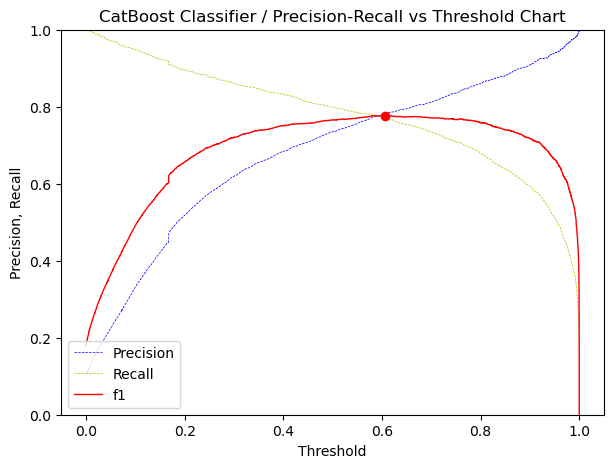

In [46]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('CatBoost Classifier / Precision-Recall vs Threshold Chart')
plt.plot(thresholds, precision[: -1], 'b--', label='Precision', lw=.5)
plt.plot(thresholds, recall[: -1], 'y--', label='Recall', lw=.5)
plt.plot(thresholds, f1_metric[: -1], 'r', label='f1', lw=1)
plt.plot(thresholds[np.argmax(f1_metric)], max(f1_metric), 'ro--', lw=4)
ax.set_ylabel('Precision, Recall')
ax.set_xlabel('Threshold')
ax.legend(loc='lower left')
ax.set_ylim([0,1])
plt.show()

In [47]:
cbc_opt_thrsh = thresholds[np.argmax(f1_metric)]
print('оптимальный порог:\t', cbc_opt_thrsh, '\nзначение f1:\t\t', max(f1_metric))

оптимальный порог:	 0.605299255375573 
значение f1:		 0.7771467905696094


## Тестирование моделей

Выведем гиперпараметры наших моделей:

In [48]:
lr_params

{'multi_class': 'ovr',
 'class_weight': 'balanced',
 'solver': 'liblinear',
 'C': 10.234333982639503}

In [49]:
cbc_params

{'loss_function': 'Logloss',
 'auto_class_weights': 'Balanced',
 'verbose': 0,
 'max_depth': 5,
 'learning_rate': 0.24845760459070187,
 'n_estimators': 1819}

### Logistic Regression

Обучаем на всех тренировочных данных, замеряем метрику `f1` на тестовых данных.

In [50]:
lr_model_tuned.fit(fch_trn, y_train)
lr_probes = lr_model_tuned.predict_proba(fch_tst)
lr_preds = np.where(lr_probes[:, 1]<=lr_opt_thrsh, 0, 1)

In [51]:
LogRegr_metrics_test = pd.DataFrame(data=[[f1_score(y_test, lr_preds),
                                           roc_auc_score(y_test, lr_probes[:, 1]),
                                           accuracy_score(y_test, lr_preds),
                                           precision_score(y_test, lr_preds),
                                           recall_score(y_test, lr_preds)]],
                                    columns=['F1', 'AUC', 'Accuracy', 'Precision', 'Recall'],
                                    index=['Logistic Regression (Test)'])
LogRegr_metrics_test

,F1,AUC,Accuracy,Precision,Recall
Logistic Regression (Test),0.780463,0.966003,0.955615,0.791064,0.770143


### CatBoost Classifier

Обучаем на всех тренировочных данных, замеряем метрику `f1` на тестовых данных.

In [52]:
CBC_model = CatBoostClassifier(**cbc_params, random_state=RND_ST)
CBC_model.fit( Pool(data=fch_trn, label=y_train), verbose=cbc_params['n_estimators']//25 )

0:	learn: 0.6074261	total: 1.1s	remaining: 33m 17s
72:	learn: 0.3247649	total: 1m 6s	remaining: 26m 40s
144:	learn: 0.2709508	total: 2m 10s	remaining: 25m 7s
216:	learn: 0.2413000	total: 3m 13s	remaining: 23m 51s
288:	learn: 0.2201987	total: 4m 17s	remaining: 22m 40s
360:	learn: 0.2039800	total: 5m 20s	remaining: 21m 33s
432:	learn: 0.1917298	total: 6m 23s	remaining: 20m 26s
504:	learn: 0.1802728	total: 7m 26s	remaining: 19m 20s
576:	learn: 0.1693218	total: 8m 29s	remaining: 18m 16s
648:	learn: 0.1608613	total: 9m 32s	remaining: 17m 11s
720:	learn: 0.1530447	total: 10m 34s	remaining: 16m 6s
792:	learn: 0.1457099	total: 11m 37s	remaining: 15m 2s
864:	learn: 0.1388674	total: 12m 40s	remaining: 13m 58s
936:	learn: 0.1329175	total: 13m 42s	remaining: 12m 54s
1008:	learn: 0.1268025	total: 14m 45s	remaining: 11m 50s
1080:	learn: 0.1216654	total: 15m 47s	remaining: 10m 46s
1152:	learn: 0.1171096	total: 16m 49s	remaining: 9m 43s
1224:	learn: 0.1129160	total: 17m 51s	remaining: 8m 39s
1296:	lea

In [53]:
cbc_probes = CBC_model.predict_proba(fch_tst)
cbc_preds = np.where(cbc_probes[:, 1]<=cbc_opt_thrsh, 0, 1)

In [54]:
CBC_metrics_test = pd.DataFrame(data=[[f1_score(y_test, cbc_preds),
                                       roc_auc_score(y_test, cbc_probes[:, 1]),
                                       accuracy_score(y_test, cbc_preds),
                                       precision_score(y_test, cbc_preds),
                                       recall_score(y_test, cbc_preds)]],
                                columns=['F1', 'AUC', 'Accuracy', 'Precision', 'Recall'],
                                index=['CatBoost Classifier (Test)'])
CBC_metrics_test

,F1,AUC,Accuracy,Precision,Recall
CatBoost Classifier (Test),0.78248,0.965615,0.955488,0.783449,0.781513


### Данные тестирования

In [55]:
pd.concat([CBC_metrics_test, LogRegr_metrics_test]).sort_values('F1', ascending=False)

,F1,AUC,Accuracy,Precision,Recall
CatBoost Classifier (Test),0.782480,0.965615,0.955488,0.783449,0.781513
Logistic Regression (Test),0.780463,0.966003,0.955615,0.791064,0.770143


Лучшая метрика `f1` у `CatBoost`, но если сравнивать по критерию "скорость-результат", то логистическая регрессия мне кажется очень неплохим вариантом, причем с достаточно хорошими результатами.

## Матрица ошибок

Для наглядности - построим матрицу ошибок для моделей

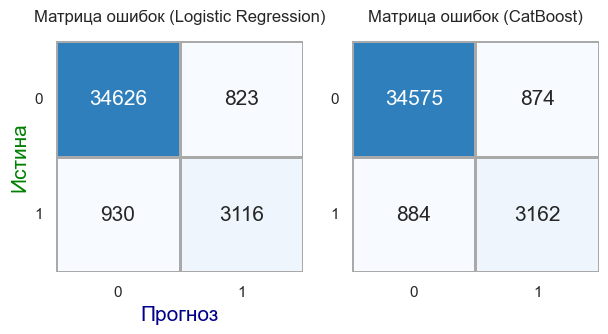

In [58]:
lr_conf_mtrx = confusion_matrix(y_test, lr_preds)
cbc_conf_mtrx = confusion_matrix(y_test, cbc_preds)
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

sns.heatmap(lr_conf_mtrx, ax=ax[0], annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=1, linecolor='darkgrey', cmap=plt.cm.Blues, center=25000)
sns.heatmap(cbc_conf_mtrx, ax=ax[1], annot=True, fmt='n', annot_kws={'fontsize':15},
            cbar=False, linewidths=1, linecolor='darkgrey', cmap=plt.cm.Blues, center=25000)

ax[0].set_title('Матрица ошибок (Logistic Regression)', fontsize=12, y=1.05)
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_xlabel('Прогноз', fontsize = 15, color='darkblue')
ax[0].set_ylabel('Истина', fontsize = 15, color='green')

ax[1].set_title('Матрица ошибок (CatBoost)', fontsize=12, y=1.05)
ax[1].tick_params(axis='y', labelrotation=0)


plt.show()

Очень показательны значения FN. CatBoost пропустил чуть меньше "токсичных" комментариев, и соответственно `Recall` у него выше. Как мне кажется, с точки зрения бизнесс задачи это важный фактор.

## Вывод

По целевой метрике `f1` обе модели показали результат, превышающий установленный задачей порог `.75`. На мой взгляд по ряду параметров Logistic Regression выглядит более выигрышным вариантом, чем лидер `CatBoost`, в первую очередь за простоту, скорость и в то же время высокие метрики.